In [1]:
import sys
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchtext import data
import nltk
import numpy as np
from argparse import ArgumentParser
from sklearn import metrics
import matplotlib.pyplot as plt
import itertools
from matplotlib import rcParams
import urllib.request
import zipfile
rcParams['axes.titlepad'] = 20 
rcParams['axes.labelpad'] = 15
%matplotlib inline

In [2]:
os.chdir('../models')
os.getcwd()

'/Users/Joe/Documents/DS_Projects/nlp-multinli/models'

In [3]:
from models import ConcatModel, CosineModel, ESIM, DA

sys.path.append('../utilities')
from tokenizers import custom_tokenizer
from utils import get_dataset, get_args

# Loading arguments

If you want to get the config from the slurm file

In [4]:
F = open('../slurm/main.slurm','r')
options = F.read().split('main.py ')[1].strip('\n')

Else, if you want to paste the args here:

In [5]:
options = "--save_model --model_type DA --max_vocab_size 15000 --n_epochs 100 --batch_size 64 --d_embed 300 "
options += "--d_hidden 300 --lr 0.0001 --dropout_mlp 0.2 --word_vectors glove.6B.300d --dev_every 550 "
options += "--DA_embed_train 70 --intra_sentence TRUE"

In [6]:
options = options.split(' ')
sys.argv = options
args = get_args()

In [7]:
args

Namespace(DA_embed_train=70, agg_d_hidden=100, agg_n_layers=1, batch_size=64, bidir=False, cuda=False, d_embed=300, d_hidden=300, dataset='multinli', dev_every=550, dropout_emb=0.0, dropout_mlp=0.2, dropout_rnn=0.0, intra_sentence=True, load_model='', lr=0.0001, max_vocab_size=15000, model_type='DA', mp_dim=15, n_epochs=100, n_layers=1, n_linear_layers=3, no_comet=False, save_model=False, sentence_len=None, val_set='val_matched', word_vectors='glove.6B.300d')

# Build datasets

In [8]:
nltk_path = os.getcwd() + '/nltk_data'
nltk.download('punkt', download_dir=nltk_path)
nltk.data.path.append(nltk_path)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/Joe/Documents/DS_Projects/nlp-
[nltk_data]     multinli/models/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Remember to delete your TSV if it doesn't have the pair_field in it yet!!!

In [9]:
text_field = data.Field(tokenize=custom_tokenizer,
                        fix_length=args.sentence_len,
                        unk_token='<**UNK**>')
label_field = data.Field(sequential=False, unk_token=None)
pair_field = data.RawField()

train = get_dataset(text_field, label_field, pair_field, 'train')
val_matched = get_dataset(text_field, label_field, pair_field, 'val_matched')
val_unmatched = get_dataset(text_field, label_field, pair_field, 'val_mismatched')

text_field.build_vocab(train, max_size=args.max_vocab_size)
label_field.build_vocab(train, val_matched, val_unmatched)

Creating Train Dataset
Creating Val_Matched Dataset
Creating Val_Mismatched Dataset


In [10]:
def sort_key(ex):
    return data.interleave_keys(len(ex.premise), len(ex.hypothesis))

In [11]:
device = -1
train_iter, val_iter_matched, val_iter_unmatched = data.BucketIterator.splits((train, val_matched, val_unmatched),
                                            batch_size=args.batch_size,
                                            shuffle = False,
                                            sort = True,
                                            sort_key = sort_key,
                                            device=device)

In [12]:
class_map = {0: 'entailment',
           1: 'contradiction',
           2: 'neutral'}

# Load model

In [13]:
saved_model = 'Model_DA_acc_71.8594_epoch_74_model.pt'
model = torch.load('../saved_models/' + saved_model)

In [14]:
model

DA (
  (embed): Embedding(15002, 300)
  (relu): ReLU ()
  (in_linear): Linear (300 -> 300)
  (mlp_F): DA_MLP (
    (mlp): Sequential (
      (Dropout_0): Dropout (p = 0.2)
      (Linear_0): Linear (600 -> 300)
      (Activation_0): ReLU ()
      (Dropout_1): Dropout (p = 0.2)
      (Linear_1): Linear (300 -> 300)
      (Activation_1): ReLU ()
    )
    (dropout): Dropout (p = 0.2)
  )
  (mlp_G): DA_MLP (
    (mlp): Sequential (
      (Dropout_0): Dropout (p = 0.2)
      (Linear_0): Linear (600 -> 300)
      (Activation_0): ReLU ()
      (Dropout_1): Dropout (p = 0.2)
      (Linear_1): Linear (300 -> 300)
      (Activation_1): ReLU ()
    )
    (dropout): Dropout (p = 0.2)
  )
  (mlp_H): DA_MLP (
    (mlp): Sequential (
      (Dropout_0): Dropout (p = 0.2)
      (Linear_0): Linear (600 -> 300)
      (Activation_0): ReLU ()
      (Dropout_1): Dropout (p = 0.2)
      (Linear_1): Linear (300 -> 300)
      (Activation_1): ReLU ()
    )
    (dropout): Dropout (p = 0.2)
  )
  (mlp_intra): DA_

In [15]:
def get_batch(data, batch_size, batch_size_fn=lambda new, count, sofar: count):
    """Yield elements from data in chunks of batch_size."""
    minibatch, size_so_far = [], 0
    for ex in data:
        minibatch.append(ex)
        size_so_far = batch_size_fn(ex, len(minibatch), size_so_far)
        if size_so_far == batch_size:
            yield minibatch
            minibatch, size_so_far = [], 0
        elif size_so_far > batch_size:
            yield minibatch[:-1]
            minibatch, size_so_far = minibatch[-1:], batch_size_fn(ex, 1, 0)
    if minibatch:
        yield minibatch

In [16]:
def evaluate(iterator, model):
    real_iter = get_batch(iterator.data(), args.batch_size)
    
    model.eval()
    n_correct = 0
    predictions = []
    labels = []
    
    premises = []
    hypothesises = []
    real_labels = []
    pair_ids = []
    
    for batch, real_batch in zip(iterator, real_iter):
        
        real_batch.reverse()
        out = model(batch)
        batch_predict = torch.max(out, 1)[1].view(batch.label.size()).data
        batch_label = batch.label.data
        n_correct += (batch_predict == batch_label).sum()
        predictions.extend(batch_predict.tolist())
        labels.extend(batch_label.tolist())
        
        premises.extend([x.premise for x in real_batch])
        hypothesises.extend([x.hypothesis for x in real_batch])
        real_labels.extend([x.label for x in real_batch])
        pair_ids.extend([x.pairID for x in real_batch])
                        
    return n_correct,\
           np.array(predictions), np.array(labels),\
           np.array(premises), np.array(hypothesises), np.array(real_labels), np.array(pair_ids)

In [42]:
def plot_confusion_matrix(true_values, predicted_values,
                          class_map = class_map,
                          classes = [0, 1, 2], 
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = metrics.confusion_matrix(true_values, predicted_values, labels = classes)

    if normalize:
        cm = np.around(100 * cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    fig, ax = plt.subplots(figsize=(8,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title, fontsize=16, fontweight='bold')
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, [class_map[i] for i in classes])
    plt.yticks(tick_marks, [class_map[i] for i in classes])

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, '{0}%'.format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 size='large')

#     plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    ax.yaxis.label.set_size(14)
    ax.xaxis.label.set_size(14)


In [18]:
def print_samples(labels, predictions, premises, hypotheses, label, prediction, samples = 5):
    idx = np.logical_and(labels == label, predictions == prediction)
    n = np.sum(idx)
    
    selection = np.random.choice(range(n), size=samples)
    
    p = premises[idx][selection]
    h = hypotheses[idx][selection]
    
    print('TRUE LABEL: %s\nPREDICTION: %s\n' % (class_map[label], class_map[prediction]))
    
    for i in range(samples):
        print('Sample %s' % (i+1))
        print('Premise: ' + ' '.join(p[i]))
        print('Hypothesis: ' + ' '.join(h[i]))
        print('-------------------------------------------------------\n')

# Annotation analysis

In [19]:
url = 'http://www.nyu.edu/projects/bowman/multinli/multinli_1.0_annotations.zip'

if not os.path.exists('../data/multinli_1.0_annotations/'):
    print('Please download the annotations into the data folder from %s' % (url))

In [20]:
matched_file = 'multinli_1.0_matched_annotations.txt'
mismatched_file = 'multinli_1.0_mismatched_annotations.txt'
matched_annotations = {}
mismatched_annotations = {}

for filename, annotations in zip([matched_file, mismatched_file], [matched_annotations, mismatched_annotations]):
    
    with open('../data/multinli_1.0_annotations/' + filename, 'r') as f:
        for line in f:
            s = line.strip().split('\t')
            annotations[s[0]] = s[1:]

In [21]:
categories = ['#CONDITIONAL', '#ACTIVE/PASSIVE', '#PARAPHRASE', '#COREF',
             '#QUANTIFIER', '#MODAL', '#BELIEF', '#NEGATION', '#ANTO',
             '#TENSE_DIFFERENCE', '#QUANTITY/TIME_REASONING', '#WORD_OVERLAP',
             '#LONG_SENTENCE']

latex_categories = ['Conditional', 'Active / Passive', 'Paraphrase',
                    'Corefer', 'Quantifier', 'Modal', 'Belief', 'Negation',
                    'Antonym', 'Tense Difference', 'Quantity / Time',
                    'Word Overlap', 'Long Sentence']

# Results!

In [49]:
def results(val_name, val_iter, annotations, model):
    n_correct, predictions, labels, premises, hypotheses, real_labels, pair_ids = evaluate(val_iter, model)  
    accuracy = n_correct / len(val_iter_matched.dataset) * 100
    print("Accuracy: {0}".format(accuracy))
    
    sub_accs = []
    
    for category in categories:
        
        num_correct = 0
        total = 0
        
        for i in range(len(pair_ids)):
            if category in annotations.get(pair_ids[i], []):
                total += 1
                
                if predictions[i] == labels[i]:
                    num_correct += 1
                    
        print('%s\t%0.2f%%' % (category.strip('#'), num_correct/total*100))
        
        sub_accs.append(num_correct/total*100)
                
    
    plot_confusion_matrix(labels, predictions, title='%s - %s\nAccuracy: %0.2f%%'
                                                  % (args.model_type, val_name, accuracy))
    for i in range(3):
        for j in range(3):
            print_samples(labels, predictions, premises, hypotheses, i, j)
            
    return  predictions, labels, premises, hypotheses, pair_ids, sub_accs

--save_model:14: DeprecationWarning: generator 'Iterator.__iter__' raised StopIteration


Accuracy: 71.85939887926644
CONDITIONAL	60.87%
ACTIVE/PASSIVE	86.67%
PARAPHRASE	84.00%
COREF	80.00%
QUANTIFIER	70.40%
MODAL	70.14%
BELIEF	59.09%
NEGATION	65.89%
ANTO	76.47%
TENSE_DIFFERENCE	66.67%
QUANTITY/TIME_REASONING	60.00%
WORD_OVERLAP	82.14%
LONG_SENTENCE	69.70%
Normalized confusion matrix
[[ 77.23   9.17  13.6 ]
 [ 13.51  72.89  13.6 ]
 [ 17.13  18.06  64.81]]
TRUE LABEL: entailment
PREDICTION: entailment

Sample 1
Premise: ah , triple pig !
Hypothesis: the pig tripled .
-------------------------------------------------------

Sample 2
Premise: you can alternate lazy days on the beach with some of the medi ? ­ter ? ­ra ? ­nean 's best deep-sea diving , boat excursions around pirate coves , canoeing and fishing on inland rivers , or hikes and picnics in the mountains .
Hypothesis: outdoor activities range from beach-going , deep-sea diving , boat excursions , canoeing , and fishing , to hikes and picnics out in the wilderness .
----------------------------------------------------

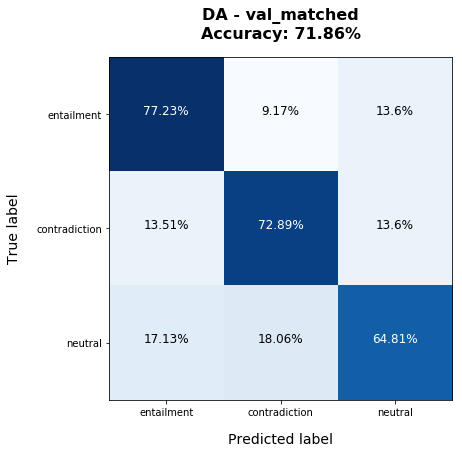

In [50]:
matched_predictions, matched_labels, matched_premises, matched_hypotheses, matched_pair_ids, matched_accs = results('val_matched', val_iter_matched, matched_annotations, model)

--save_model:14: DeprecationWarning: generator 'Iterator.__iter__' raised StopIteration


Accuracy: 71.62506367804382
CONDITIONAL	61.54%
ACTIVE/PASSIVE	70.00%
PARAPHRASE	84.21%
COREF	76.67%
QUANTIFIER	65.00%
MODAL	69.84%
BELIEF	76.27%
NEGATION	73.08%
ANTO	85.00%
TENSE_DIFFERENCE	72.22%
QUANTITY/TIME_REASONING	54.17%
WORD_OVERLAP	72.97%
LONG_SENTENCE	65.14%
Normalized confusion matrix
[[ 78.08   8.81  13.11]
 [ 13.46  72.96  13.58]
 [ 19.53  17.77  62.7 ]]
TRUE LABEL: entailment
PREDICTION: entailment

Sample 1
Premise: faa headquarters had by this time established an open line of communication with the command center at herndon and instructed it to poll all its centers about suspect aircraft .
Hypothesis: the herndon command center was told to ask about suspect aircraft at all centers belonging to it .
-------------------------------------------------------

Sample 2
Premise: during the course of the morning , there were multiple erroneous reports of hijacked aircraft .
Hypothesis: there were many reports that morning with incorrect information about the hijacking .
-------

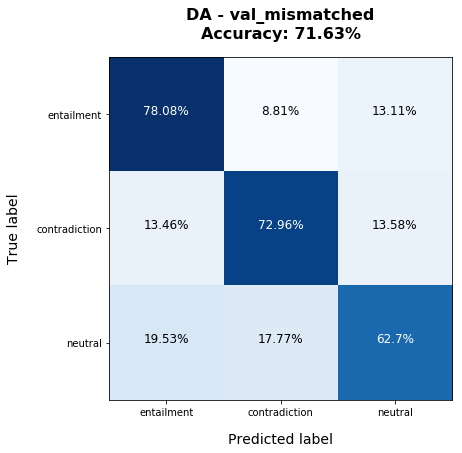

In [51]:
mismatched_predictions, mismatched_labels, mismatched_premises, mismatched_hypotheses, mismatched_pair_ids, mismatched_accs = results('val_mismatched', val_iter_unmatched, mismatched_annotations, model)

# Because I know you're lazy: LaTeX table!

In [25]:
latex = """\\begin{tabular}{l | c | c}
\\textbf{Category} & Matched (\%) & Mismatched (\%) \\\\
\hline \\\\
"""

for i in range(len(latex_categories)):
    latex += latex_categories[i] + ' & %.2f & %.2f \\\\ \n' % (matched_accs[i], mismatched_accs[i])

latex += '\end{tabular}'

print(latex)

\begin{tabular}{l | c | c}
\textbf{Category} & Matched (\%) & Mismatched (\%) \\
\hline \\
Conditional & 60.87 & 61.54 \\ 
Active / Passive & 86.67 & 70.00 \\ 
Paraphrase & 84.00 & 84.21 \\ 
Corefer & 80.00 & 76.67 \\ 
Quantifier & 70.40 & 65.00 \\ 
Modal & 70.14 & 69.84 \\ 
Belief & 59.09 & 76.27 \\ 
Negation & 65.89 & 73.08 \\ 
Antonym & 76.47 & 85.00 \\ 
Tense Difference & 66.67 & 72.22 \\ 
Quantity / Time & 60.00 & 54.17 \\ 
Word Overlap & 82.14 & 72.97 \\ 
Long Sentence & 69.70 & 65.14 \\ 
\end{tabular}


# Attention graph (only for ESIM and DA)

Get a single batch, stupid but I don't know how else to do it

In [26]:
def single_batch(iterator, num):
    
    real_iter = get_batch(iterator.data(), args.batch_size)
    
    i = 0
    
    for batch, real_batch in zip(iterator, real_iter):
        i += 1
        if i >= num:
            break
            
    real_batch.reverse()
    
    return batch, real_batch
    

In [27]:
def get_masks(input, pad_token=1):
    return (input != pad_token).unsqueeze(2).float()

def softmask(input, mask):
    """
    input is of dims batch_size x len_1 x len_2
    mask if of dims batch_size x len_2 x 1
    """
    batch_size, len_1, len_2 = input.size()

    assert len_2 == mask.size(1)

    exp_input = torch.exp(input)
    divisors = torch.bmm(exp_input, mask).view(batch_size, len_1)  # batch_size x len_1
    masked = torch.mul(exp_input, torch.transpose(mask.expand(batch_size, len_2, len_1), 1, 2))

    return masked.div(divisors.unsqueeze(2).expand_as(masked))  # batch_size x len_1 x len_2

In [28]:
def get_attn_DA(model, x):
    
    p = torch.transpose(x.premise, 0, 1)
    h = torch.transpose(x.hypothesis, 0, 1)

    batch_size = p.size(0)

    ### Get max sequence lengths ###
    p_length = p.size(1)
    h_length = h.size(1)

    ### Get masks for true sequence length ###
    p_mask = get_masks(p)
    h_mask = get_masks(h)

    # Embed premise & hypothesis
    p_embedded = model.embed(p)
    h_embedded = model.embed(h)

    # Apply initial linear encoding
    p_linear = model.in_linear(p_embedded.view(batch_size * p_length, -1)).view(batch_size, p_length, -1)
    h_linear = model.in_linear(h_embedded.view(batch_size * h_length, -1)).view(batch_size, h_length, -1)

    if model.intra_sentence:
        p_intra = model.mlp_intra(p_linear.view(batch_size * p_length, -1)).view(batch_size, p_length, -1)
        h_intra = model.mlp_intra(h_linear.view(batch_size * h_length, -1)).view(batch_size, h_length, -1)

        # Self Attend
        p_self_scores = torch.bmm(p_intra, torch.transpose(p_intra, 1, 2))
        p_probs = softmask(p_self_scores, p_mask)
        p_intra = torch.cat((p_linear, torch.bmm(p_probs, p_linear)), 2)

        h_self_scores = torch.bmm(h_intra, torch.transpose(h_intra, 1, 2))
        h_probs = softmask(h_self_scores, h_mask)
        h_intra = torch.cat((h_linear, torch.bmm(h_probs, h_linear)), 2)
        
        # Apply F
        F_p = model.mlp_F(p_intra.view(batch_size * p_length, -1)).view(batch_size, p_length, -1)
        F_h = model.mlp_F(h_intra.view(batch_size * h_length, -1)).view(batch_size, h_length, -1)

    else:
        # Apply F
        F_p = model.mlp_F(p_linear.view(batch_size * p_length, -1)).view(batch_size, p_length, -1)
        F_h = model.mlp_F(h_linear.view(batch_size * h_length, -1)).view(batch_size, h_length, -1)

    # Attend
    sim_scores = torch.bmm(F_p, torch.transpose(F_h, 1, 2))
    
    p_probs = softmask(sim_scores, h_mask)
    
    return p_probs.data.numpy(), h_probs.data.numpy(), p_mask.data.numpy(), h_mask.data.numpy()

In [29]:
def get_attn_ESIM(model, x):

    p = x.premise #[sentence_length x batch_size]
    h = x.hypothesis #[sentence_length x batch_size]

    ### Get max sequence lengths ###
    p_length = p.size(0)
    h_length = h.size(0)

    ### Get masks for true sequence length ###
    mask_p = get_masks(p).transpose(0, 1)
    mask_h = get_masks(h).transpose(0, 1)

    ### Embed inputs ###
    p = model.emb_drop(model.embed(p))
    h = model.emb_drop(model.embed(h))

    ### First biLSTM layer ###
    premise_bi, states = model.premise(p)
    hypothesis_bi, states = model.hypothesis(h)

    ### Attention ###
    premise_bi = premise_bi.transpose(0, 1)
    hypothesis_bi = hypothesis_bi.transpose(0, 1)

    sim_scores = torch.bmm(premise_bi, torch.transpose(hypothesis_bi, 1, 2))

    p_probs = softmask(sim_scores, mask_h)
    h_probs = softmask(torch.transpose(sim_scores, 1, 2), mask_p)

    return p_probs.data.numpy(), h_probs.data.numpy(), mask_p.data.numpy(), mask_h.data.numpy()

In [30]:
def make_plot(h_attn, p, h):   
    h_attn = h_attn[:len(h), :len(p)]

    plt.figure(figsize=(6, 6))
    plt.imshow(np.transpose(h_attn), cmap=plt.cm.Blues)
    x_ticks = np.arange(len(h))
    plt.xticks(x_ticks, h, rotation=90)
    plt.xlabel('Hypothesis')
    y_ticks = np.arange(len(p))
    plt.yticks(y_ticks, p)
    plt.ylabel('Premise')

    plt.tight_layout()


In [31]:
values, words = single_batch(val_iter_matched, 30)
# p_attns, h_attns, mask_p, mask_h = get_attn_ESIM(model, values)
p_attns, h_attns, mask_p, mask_h = get_attn_DA(model, values)

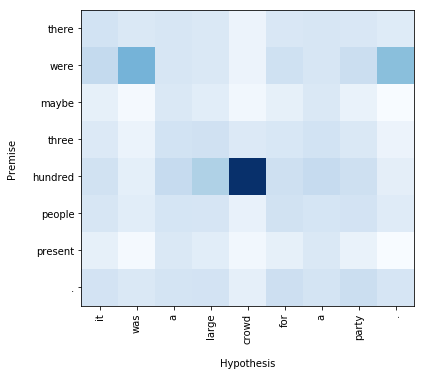

In [32]:
i = 8
make_plot(h_attns[i], words[i].premise, words[i].hypothesis)

In [68]:
matched_predictions[list(matched_pair_ids).index('8989n')]

2